In [74]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import qt3utils.experiments.cwodmr
import qt3utils.nidaq.config

In [3]:
import qcsapphire
import qt3rfsynthcontrol
import numpy as np
import matplotlib.pyplot as plt
import time

In [24]:
pulser = qcsapphire.Pulser('COM10')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [55]:
trigger_pulser_channel = None
trigger_DAQ_terminal = None

rf_on_off_period = 10e-3

cwodmr = qt3utils.experiments.cwodmr.CWODMR(rfsynth, 
                                            freq_low = 2846e6, 
                                            freq_high = 2890e6, 
                                            freq_step = 4e6,
                                            sample_period = rf_on_off_period) 

cwodmr.setup_qcsapphire_pulser(pulser, 'B', trigger_channel = trigger_pulser_channel,
                               rf_pulse_width=.001, # (50ms on, 50 ms off)
                               rf_pulse_delay = 0,
                               qcsapphire_system_buffer=0)

pulser.channel('B').state(0)
pulser.multiplex(['C','B'], 'D')
pulser.channel('D').state(1)

'ok'

In [53]:
qt3utils.nidaq.config.reset_daq('Dev1')

In [56]:
sample_period = 1e-6 #minimum is 0.1e-6
clock_rate = int(1./sample_period) 
N_samples = int(1 * clock_rate) #X seconds of data per frequency
daq_time = N_samples / clock_rate #total amount of time of data acquisition for each counter task
N_cycles =  daq_time /cwodmr.sample_period 
N_samples_per_cycle = cwodmr.sample_period * clock_rate

In [57]:
print(cwodmr.sample_period)
print(clock_rate)
print(N_samples)
print(daq_time)
print(N_cycles)
print(N_samples_per_cycle)

0.01
1000000
1000000
1.0
100.0
10000.0


In [58]:
edge_config = qt3utils.nidaq.config.EdgeCounter()
edge_config.configure_di_clock(clock_rate = clock_rate)

edge_config.configure_counter_period_measure(edge_config.clock_task_config['clock_channel_name'], 
                                             N_samples_to_acquire_or_buffer_size= N_samples,
                                            trigger_terminal=trigger_DAQ_terminal)


edge_config.create_counter_reader()

In [62]:
edge_config.clock_task.start()
data = []
rf_power = -15

for freq in cwodmr.frequencies:
    print(freq)
    rfsynth.set_channel_fixed_output(0, rf_power, freq)
    rfsynth.rf_on(0)
    time.sleep(0.05) #wait for RF box to turn on
    data_buffer = np.zeros(N_samples)
    edge_config.counter_task.start()
    time.sleep(daq_time*1.1)
    read_samples = edge_config.counter_reader.read_many_sample_double(
                            data_buffer,
                            number_of_samples_per_channel=N_samples,
                            timeout=5)
    rfsynth.rf_off(0)
    time.sleep(0.05) #wait for RF box
    edge_config.counter_task.stop()
    data.append([freq, data_buffer])
edge_config.clock_task.stop()


2846000000.0
2850000000.0
2854000000.0
2858000000.0
2862000000.0
2866000000.0
2870000000.0
2874000000.0
2878000000.0
2882000000.0
2886000000.0
2890000000.0


In [63]:
#rf pulse was 50% of pulser period.
#summed_data_rf_duty_half = {data_per_freq[0]:data_per_freq[1].sum()/daq_time for data_per_freq in data}

#change the rf pulse width to 10% of pulser period and run again. We should see less contrast
#summed_data_rf_duty_tenth = {data_per_freq[0]:data_per_freq[1].sum()/daq_time for data_per_freq in data}

#change the rf pulse width to 1% of pulser period and run again. We should see less contrast
#summed_data_rf_duty_hundredth = {data_per_freq[0]:data_per_freq[1].sum()/daq_time for data_per_freq in data}

#rf pulse was turned off
#summed_data_rf_duty_zero = {data_per_freq[0]:data_per_freq[1].sum()/daq_time for data_per_freq in data}

#rf pulse was disconnected
summed_data_rf_duty_disconnected = {data_per_freq[0]:data_per_freq[1].sum()/daq_time for data_per_freq in data}

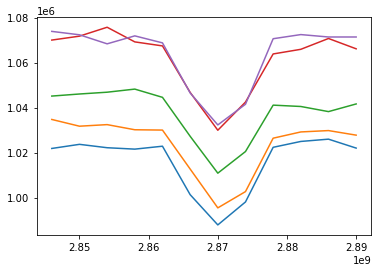

In [64]:
plt.plot(summed_data_rf_duty_half.keys(), summed_data_rf_duty_half.values())
plt.plot(summed_data_rf_duty_tenth.keys(), summed_data_rf_duty_tenth.values())
plt.plot(summed_data_rf_duty_hundredth.keys(), summed_data_rf_duty_hundredth.values())
plt.plot(summed_data_rf_duty_zero.keys(), summed_data_rf_duty_zero.values())
plt.plot(summed_data_rf_duty_disconnected.keys(), summed_data_rf_duty_disconnected.values())

Conclusion from above : the switch is broken. RF is leaking through even with the TTL pulse physically disconnected from the switch. 

Also, strange that total counts increased overall from each run.... 

Actually, the contrast isn't changing at ALL!  Total counts are drifting..

Doesn't seem like the switch is working

In [65]:
print(cwodmr.sample_period)
print(clock_rate)
print(N_samples)
print(daq_time)
print(N_cycles)
print(N_samples_per_cycle)

0.01
1000000
1000000
1.0
100.0
10000.0


2862000000.0
2846000000.0


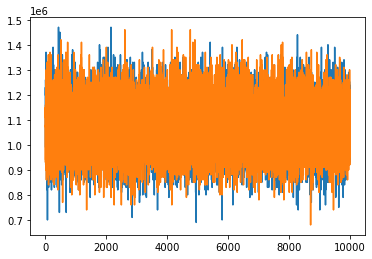

In [66]:
shift = 0
print(data[4][0])
data_buffer_by_cycles = np.roll(data[4][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate)

print(data[0][0])
data_buffer_by_cycles = np.roll(data[0][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate)

2.846 GHz : 1073851.0
2.85 GHz : 1072336.0
2.854 GHz : 1068320.0000000002
2.858 GHz : 1071858.0
2.862 GHz : 1068748.0
2.866 GHz : 1046499.0000000001
2.87 GHz : 1032281.9999999999
2.874 GHz : 1041464.0
2.878 GHz : 1070593.0000000002
2.882 GHz : 1072431.0
2.886 GHz : 1071359.9999999998
2.89 GHz : 1071359.0


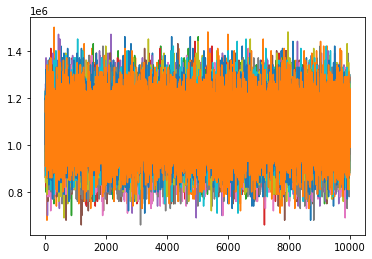

In [73]:

for i in range(len(data)):
    data_buffer_by_cycles = np.roll(data[i][1], shift).reshape((int(N_cycles), int(N_samples_per_cycle)))
    plt.plot(data_buffer_by_cycles.mean(axis=0) * clock_rate)
    print(f'{data[i][0]*1e-9} GHz : {data_buffer_by_cycles.mean(axis=0).mean() * clock_rate}')